In [1]:
import numpy as np
import gurobipy as gp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in the data
df1 = pd.read_csv('locations1.csv')
df1

x         y
0    0.321665 -0.277641
1    0.838688 -0.565661
2    0.778286  0.130336
3    0.755618  0.065864
4    1.298365  0.255950
..        ...       ...
495  0.811267 -0.588174
496  0.899385 -0.231154
497  1.330741 -0.535550
498  0.519848 -0.265574
499  1.124586 -0.998174

[500 rows x 2 columns]

# Clustering and Distance Matrices

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


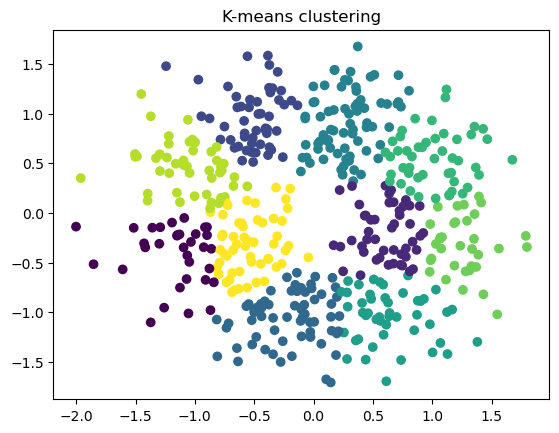

In [3]:
# Find the location clusters using K-means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
kmeans.fit(df1)
df1['cluster'] = kmeans.labels_

# Plot the clusters
plt.scatter(df1['x'], df1['y'], c=df1['cluster'])
plt.title('K-means clustering')
plt.show()

In [4]:
# Put each cluster into a dataframe
dfc0 = df1.loc[df1['cluster'] == 0].reset_index(drop=False)
dfc1 = df1.loc[df1['cluster'] == 1].reset_index(drop=False)
dfc2 = df1.loc[df1['cluster'] == 2].reset_index(drop=False)
dfc3 = df1.loc[df1['cluster'] == 3].reset_index(drop=False)
dfc4 = df1.loc[df1['cluster'] == 4].reset_index(drop=False)
dfc5 = df1.loc[df1['cluster'] == 5].reset_index(drop=False)
dfc6 = df1.loc[df1['cluster'] == 6].reset_index(drop=False)
dfc7 = df1.loc[df1['cluster'] == 7].reset_index(drop=False)
dfc8 = df1.loc[df1['cluster'] == 8].reset_index(drop=False)
dfc9 = df1.loc[df1['cluster'] == 9].reset_index(drop=False)

#Add the distribution center to each cluster
dfc0.loc[len(dfc0)] = [500, 0, 0, 10]
dfc1.loc[len(dfc1)] = [500, 0, 0, 10]
dfc2.loc[len(dfc2)] = [500, 0, 0, 10]
dfc3.loc[len(dfc3)] = [500, 0, 0, 10]
dfc4.loc[len(dfc4)] = [500, 0, 0, 10]
dfc5.loc[len(dfc5)] = [500, 0, 0, 10]
dfc6.loc[len(dfc6)] = [500, 0, 0, 10]
dfc7.loc[len(dfc7)] = [500, 0, 0, 10]
dfc8.loc[len(dfc8)] = [500, 0, 0, 10]
dfc9.loc[len(dfc9)] = [500, 0, 0, 10]

#Append all the cluster dataframes into a list
df_list = []
df_list.append(dfc0)
df_list.append(dfc1)
df_list.append(dfc2)
df_list.append(dfc3)
df_list.append(dfc4)
df_list.append(dfc5)
df_list.append(dfc6)
df_list.append(dfc7)
df_list.append(dfc8)
df_list.append(dfc9)

In [5]:
def get_distance_matrix(df): 
    ''' This function takes a dataframe with x and y coordinates and returns a distance matrix'''

    # Get the number of locations
    N = df.shape[0]

    distMat = np.zeros((N,N)) # Distance matrix
    for i in range(N):
        for j in range(N):
            if i == j:
                # So we don't go from the same place to the same place
                distMat[i,j] = 1000
            else:
                # Euclidean distance
                distMat[i,j] = np.sqrt((df.x[i]-df.x[j])**2 + (df.y[i]-df.y[j])**2)
    return distMat

In [6]:
# Store the distance matrices in a list
clusters = 10
list_of_distance_matrices = []
for cluster in range(clusters):
    list_of_distance_matrices.append(get_distance_matrix(df_list[cluster]))

# Optimization

In [7]:
# Find the optimal distance for each cluster/truck
optimal_distances = []
route_for_each_cluster = []
for cluster in range(clusters):
    print('Working on cluster', cluster)
    N = df_list[cluster].shape[0]
    mod = gp.Model()
    x = mod.addMVar((N,N),vtype='B')
    u = mod.addMVar(N)

    # enter each city once, j fixed
    # each column add to 1
    enter = mod.addConstrs((gp.quicksum(x[i,j] for i in range(N))==1) for j in range(N))
    # leave each city once, i fixed
    # each row add to 1
    leave = mod.addConstrs((gp.quicksum(x[i,j] for j in range(N))==1) for i in range(N))
    # u constraints
    ucons = mod.addConstrs((u[i] - u[j] + N*x[i,j] <= (N-1)) for i in range(1,N) for j in range(1,N) if i != j)

    # i is the row here, j is the column
    mod.setObjective(gp.quicksum(x[i,j]*list_of_distance_matrices[cluster][i,j] for i in range(N) for j in range(N)))

    mod.Params.OutputFlag = 0 # tell gurobi to shut up!!
    mod.setParam('TimeLimit', 5*60)
    mod.optimize()

    optimal_distances.append(mod.objVal)
    route_for_each_cluster.append(x.x)

Working on cluster 0
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-23
Working on cluster 1
Working on cluster 2
Working on cluster 3
Working on cluster 4
Working on cluster 5
Working on cluster 6
Working on cluster 7
Working on cluster 8
Working on cluster 9


In [8]:
# Print the optimal route for each cluster/truck in a readable format
for cluster in range(clusters):
    print(f'Optimal route for truck (cluster) number: {cluster}')
    N = df_list[cluster].shape[0]
    where = 0
    miles_traveled = 0
    print('Start at the distribution center, location = 0')
    for location in reversed(range(N)):
        # Start in the new location (go to the row with the new city)
        # We find the next location by using where() to find the first nonzero element (logical indexing, 1 = True) in the row
        where_new = np.where(route_for_each_cluster[cluster][where,:])[0][0]
        dist = list_of_distance_matrices[cluster][where,where_new]
        miles_traveled += dist
        print('Then go to location '+str(df_list[cluster]['index'].iloc[where_new])+', traveling '+str(dist)+' miles along the way.')
        # Store the next location as the starting location, since we have now traveled to it
        where = where_new
    print('For a total of '+str(miles_traveled)+' miles.')
    print()

Optimal route for truck (cluster) number: 0
Start at the distribution center, location = 0
Then go to location 325, traveling 0.10996496985025334 miles along the way.
Then go to location 278, traveling 0.06708690473677088 miles along the way.
Then go to location 265, traveling 0.15658646464894785 miles along the way.
Then go to location 270, traveling 0.4863715755041809 miles along the way.
Then go to location 280, traveling 0.4063288978988391 miles along the way.
Then go to location 268, traveling 0.2506714672221009 miles along the way.
Then go to location 313, traveling 0.2921106075135596 miles along the way.
Then go to location 316, traveling 0.041884791664101965 miles along the way.
Then go to location 306, traveling 0.1286244372333286 miles along the way.
Then go to location 276, traveling 0.16973727275573725 miles along the way.
Then go to location 263, traveling 0.008979870368471542 miles along the way.
Then go to location 320, traveling 0.017595811479340348 miles along the way.

In [9]:
# Sum of the optimal distances for all clusters/trucks
print('Total miles traveled: ', sum(optimal_distances))

Total miles traveled:  66.98296653066188


Text(0.5, 1.0, 'Optimal Routes for Each Truck')

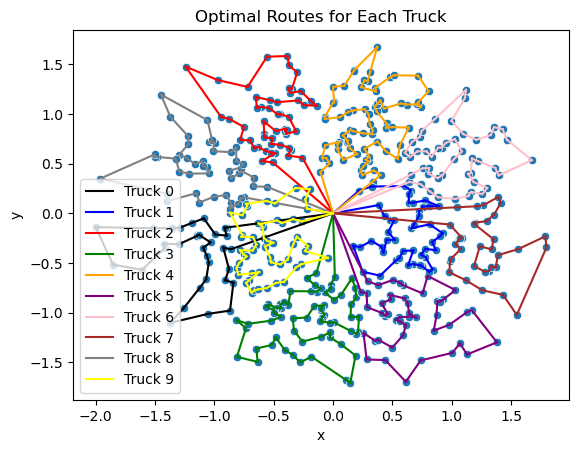

In [10]:
# Plot the graph showing the traveling routes for all clusters/trucks
color_list = ['black','blue','red','green','orange','purple','pink','brown','gray','yellow']
sns.scatterplot(x='x',y='y',data=df1)
# Create a dictionary to store the legend
label_dict = {}
# Plot the routes
for cluster in range(clusters):
    N = df_list[cluster].shape[0]
    if color_list[cluster] not in label_dict:
        label_dict[color_list[cluster]] = f'Truck {cluster}'
    for i in range(N):
        for j in range(N):
            if route_for_each_cluster[cluster][i,j] > 0.9:
                plt.plot([df_list[cluster].x[i],df_list[cluster].x[j]],[df_list[cluster].y[i],df_list[cluster].y[j]],color=color_list[cluster])
# Print the legend
for color, label in label_dict.items():
    plt.plot([], [], color=color, label=label)
plt.legend()
plt.title("Optimal Routes for Each Truck")

# How many drivers?

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


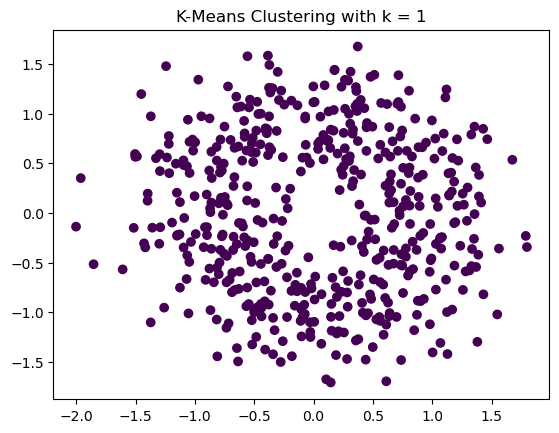

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


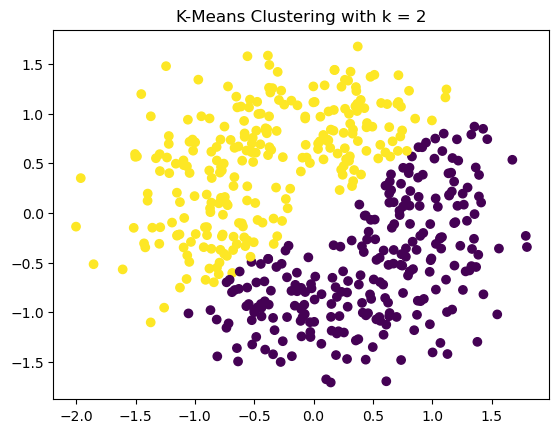

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


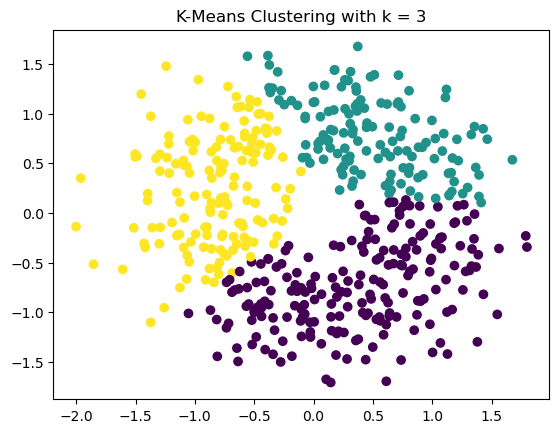

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


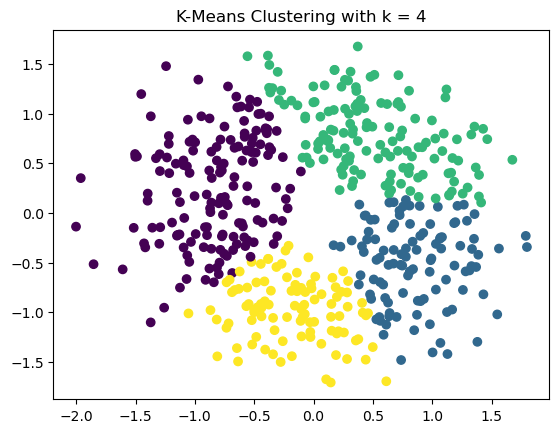

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


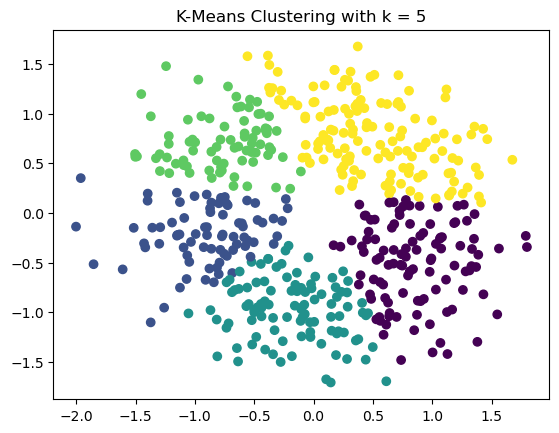

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


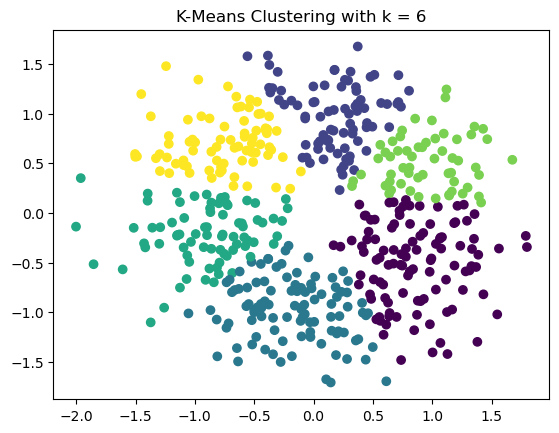

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


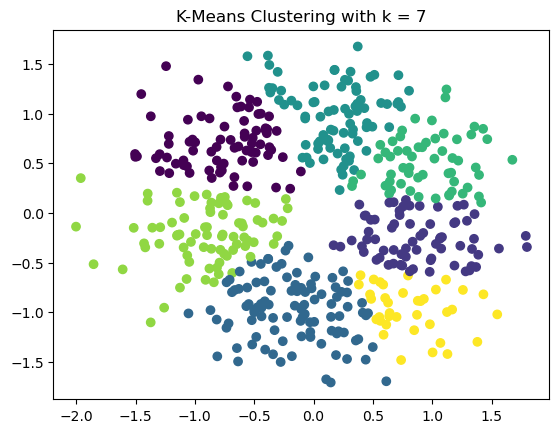

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


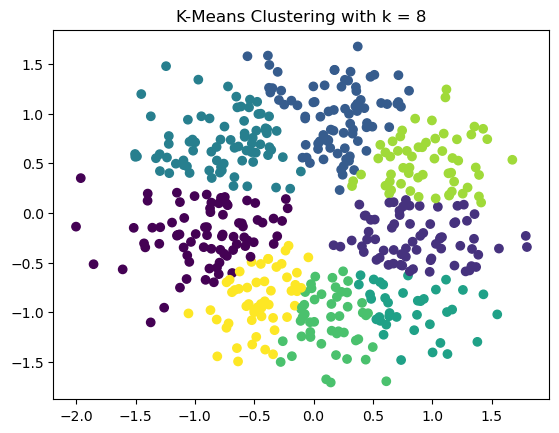

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


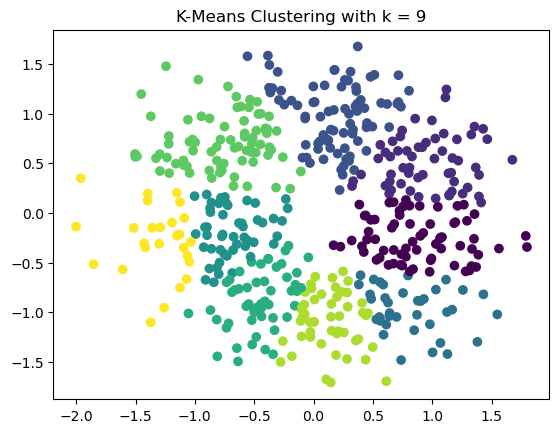

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


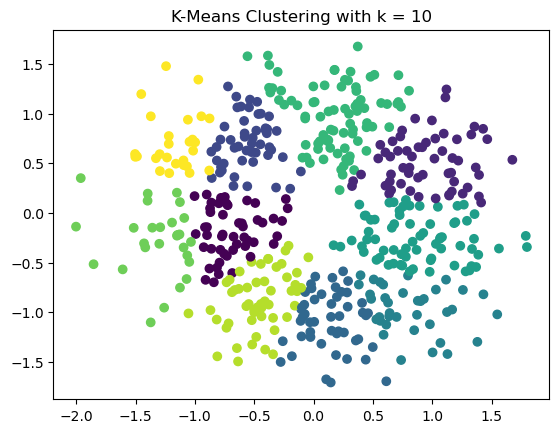

In [11]:
# For k-means up to 10, we group the data into k clusters and plot the clusters
from sklearn.cluster import KMeans
# a list that store different type of clusters for different K-means
df_list = []
for  k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df1)
    df1['cluster'] = kmeans.labels_

    # Plot the clusters
    plt.scatter(df1['x'], df1['y'], c=df1['cluster'])
    plt.title('K-Means Clustering with k = '+str(k))
    plt.show()

    # Put each cluster into a dataframe
    dfc_list = []
    for i in range(k):
        dfc_list.append(df1.loc[df1['cluster'] == i].reset_index(drop=False))
    for j in range(k):
        dfc_list[j].loc[len(dfc_list[j])] = [500, 0, 0, 10]
    # add into the list, in that case df_list has 10 different clusters.
    # for example, df_list[1] represents the K-means clustering with k = 2  
    df_list.append(dfc_list)

In [12]:
# For each cluster in each k, we calculate the distance between each pair of locations in each cluster
dist_list_in_each_K_mean = []
for k in range(1,11):
    dist_list = []
    for df in df_list[k-1]:
        # The code below is to calculate the distance between each pair of locations
        nx = df.shape[0]
        dist = np.zeros((nx,nx))
        for i in range(nx):
            for j in range(nx):
                # If the two locations are the same, set the distance to be a large number
                if i == j:
                    dist[i,j] = 10000
                # Else calculate the distance between the two locations
                else:
                    dist[i,j] = np.sqrt((df['x'][i]-df['x'][j])**2 + (df['y'][i]-df['y'][j])**2)
        dist_list.append(dist)
    # add the distance of locations in different K-Means in a list    
    dist_list_in_each_K_mean.append(dist_list)

In [13]:
# We use the transport function to generate a new path
def transport(path):
    nx = len(path)
    # We randomly choose two locations as the start and end points
    startstop = np.random.choice(nx,2,replace=False)
    # If the start point is larger than the end point, the start is the end and the end is the start
    if startstop[0] > startstop[1]:
        # Find the path to be removed
        remove_path = np.append(path[startstop[0]:],path[:(startstop[1]+1)])
        # The closed path is the path that is not removed
        closed_path = path[(startstop[1]+1):startstop[0]]
    # If the start point is smaller than the end point, the start is the start and the end is the end
    else:
        # Find the path to be removed
        remove_path = path[startstop[0]:(startstop[1]+1)]
        # The closed path is the path that is not removed
        closed_path = np.append(path[0:startstop[0]],path[(startstop[1]+1):])
    # The number of locations in the closed path
    nc = len(closed_path)
    # If the number of locations in the closed path is greater than 0, we randomly choose a location in the closed path
    if nc > 0:
        paste = np.random.choice(nc,1)[0]
        # We paste the removed path to the randomly chosen location in the closed path
        newpath = np.append(closed_path[0:(paste+1)],remove_path)
        newpath = np.append(newpath,closed_path[(paste+1):])
    # If the number of locations in the closed path is 0, the new path is the same as the old
    else:
        newpath = path
    return newpath

In [14]:
# We use the reverse function to generate a new path
def reverse(path):
    nx = len(path)
    # We randomly choose two locations as the start and end points
    startstop = np.random.choice(nx,2,replace=False)
    # If the start point is larger than the end point, the start is the end and the end is the start
    if startstop[0] > startstop[1]:
        # Find the path to be removed
        remove_path = np.append(path[startstop[0]:],path[:(startstop[1]+1)])
        # Reverse the path to be removed
        remove_path = remove_path[::-1]
        # The closed path is the path that is not removed
        closed_path = path[(startstop[1]+1):startstop[0]]
        # The new path is the closed path plus the reversed path
        new_path = np.append(closed_path,remove_path)
    # If the start point is smaller than the end point, the start is the start and the end is the end
    else:
        # Find the path to be removed
        remove_path = path[startstop[0]:(startstop[1]+1)]
        # Reverse the path to be removed
        remove_path = remove_path[::-1]
        # To create the new path, we add the removed path to the end of the first part of the original path
        new_path = np.append(path[0:startstop[0]],remove_path)
        # Add the remaining part of the original path to the end of the new path
        new_path = np.append(new_path,path[(startstop[1]+1):])
    return new_path

In [15]:
# We find the total distance of the path
def measure_path(path,dist):
    nx = len(path)
    total_dist = 0
    for i in range(nx-1):
        # Find the distance between each the starting and ending points of the path
        total_dist += dist[path[i],path[i+1]]
    # Add the distance between the last point and the first point
    total_dist += dist[path[nx-1],path[0]]
    return total_dist

In [16]:
# Simulated annealing
# the run time is between 6 - 40 mins depenent on the quality of the laptop
# it is time to check your device quality.
optimal_route_list_in_each_K_mean = []
optimal_dist_list_in_each_K_mean = []
for k in range(1,11):
    print('working on k = ',k,'...')
    optimal_route_list = []
    optimal_dist_list = []
    for cluster in range(len(df_list[k-1])):
        print('working on cluster = ',cluster,'...')
        nx = df_list[k-1][cluster].shape[0]
        path = np.random.choice(nx,nx,False)
        nloop = 100000
        eps = 1
        delta = 1/nloop
        total_dist = measure_path(path,dist_list_in_each_K_mean[k-1][cluster])
        # Randomly choose a method to generate a new path
        for j in range(nloop):
            if np.random.random() < 0.5:
                newpath = transport(path)
            else:
                newpath = reverse(path)
            newdist = measure_path(newpath,dist_list_in_each_K_mean[k-1][cluster])
            # If the new path is shorter, we accept the new path
            if newdist < total_dist:
                path = newpath
                total_dist = newdist
            # If the new path is longer, we accept the new path with a probability
            # This is to prevent us from entering a local minimum
            # The more distance we add, the less likely we are to accept the new path
            else:
                if np.random.random() < eps/np.exp(newdist-total_dist):
                    path = newpath
                    total_dist = newdist
            # Every loop we reduce the probability of accepting the new path
            eps -= delta
        optimal_route_list.append(path)
        optimal_dist_list.append(total_dist)
    # add the route and distance we calculated for each K-Mean inside the list.
    optimal_route_list_in_each_K_mean.append(optimal_route_list)
    optimal_dist_list_in_each_K_mean.append(optimal_dist_list)

working on k =  1 ...
working on cluster =  0 ...
working on k =  2 ...
working on cluster =  0 ...
working on cluster =  1 ...
working on k =  3 ...
working on cluster =  0 ...
working on cluster =  1 ...
working on cluster =  2 ...
working on k =  4 ...
working on cluster =  0 ...
working on cluster =  1 ...
working on cluster =  2 ...
working on cluster =  3 ...
working on k =  5 ...
working on cluster =  0 ...
working on cluster =  1 ...
working on cluster =  2 ...
working on cluster =  3 ...
working on cluster =  4 ...
working on k =  6 ...
working on cluster =  0 ...
working on cluster =  1 ...
working on cluster =  2 ...
working on cluster =  3 ...
working on cluster =  4 ...
working on cluster =  5 ...
working on k =  7 ...
working on cluster =  0 ...
working on cluster =  1 ...
working on cluster =  2 ...
working on cluster =  3 ...
working on cluster =  4 ...
working on cluster =  5 ...
working on cluster =  6 ...
working on k =  8 ...
working on cluster =  0 ...
working on c

In [17]:
# For each k, we print the optimal route and the total distance for each cluster
for k in range(1,11):
    for i in range(len(optimal_route_list_in_each_K_mean[k-1])):
        print( 'k means',k)
        print( 'For cluster:',i)
        print('Optimal route:',optimal_route_list_in_each_K_mean[k-1][i])
        print('Total distance:',optimal_dist_list_in_each_K_mean[k-1][i])

k means 1
For cluster: 0
Optimal route: [334 310 307 355 322 260 272 289 349 340 392 394 345 379 427 361 235 207
 328 146 448  19  96 103 128  87 137  61 120 162 174 177 247 195 182 252
 333 305 321 267 261 327 232 303 262 383 380 359 398 384 417 420 364 433
 491 424 428 416 497  28 450 489  21  72  29  76  58  23 129 157 197 191
 117 243 230 104 122  69 118  90  81  56  88  91  18 463  82  75 135  95
  39  15 113  97  79  51 143  93  85  11  35  94  47   5 479  26 112 101
 111 402 419 472 469 449 492 478 499 477 485 460 462  40  64  71  92  20
 390 339 325 253 434 201 171 172 281 288 297 306 320 296 217 219 181 211
 178 199 159  50   3   0 133 500 160  55 284  77 108  89  17  33 471 465
 410   7  13   2  38 451  27  25  14  37 453  46  22 490  41  10 480 312
 375 412 365 421 395 429 438 413 439 373 360 331 311 251 226 257 298 244
 285 246 173 152 237 256 317 213 176 208 250 204 280 214 342 313 294 202
 347 255 407 444 437 352 354 447 404 399 415 443 389 493   1 155  74 254
 153 271 24

In [18]:
# For each k means, print the total distance of all clusters
for k in range(1,11):
    print('k means',k)
    print('The total distance of all clusters:',sum(optimal_dist_list_in_each_K_mean[k-1]))

k means 1
The total distance of all clusters: 223.85386913967685
k means 2
The total distance of all clusters: 156.65146355608442
k means 3
The total distance of all clusters: 132.25940274897877
k means 4
The total distance of all clusters: 119.10939059411493
k means 5
The total distance of all clusters: 111.62982853571646
k means 6
The total distance of all clusters: 102.93433831497137
k means 7
The total distance of all clusters: 99.6254926776368
k means 8
The total distance of all clusters: 91.38711213193871
k means 9
The total distance of all clusters: 89.16094499818014
k means 10
The total distance of all clusters: 87.5682100557379


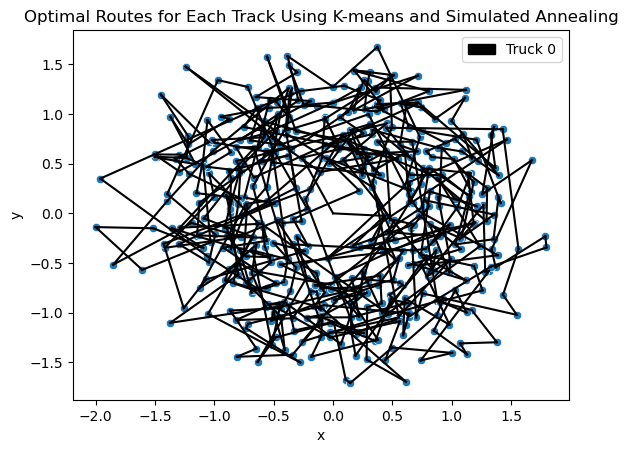

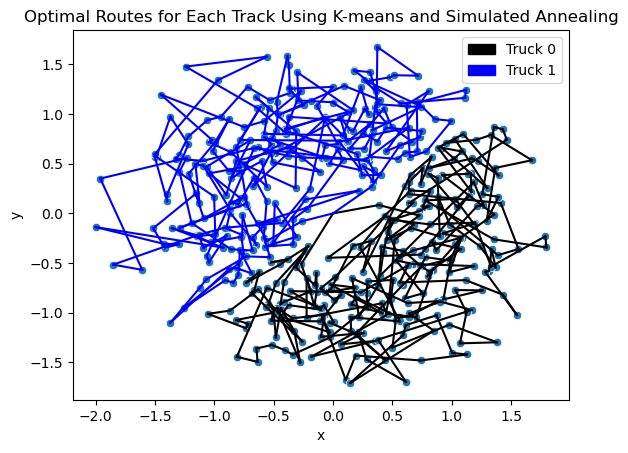

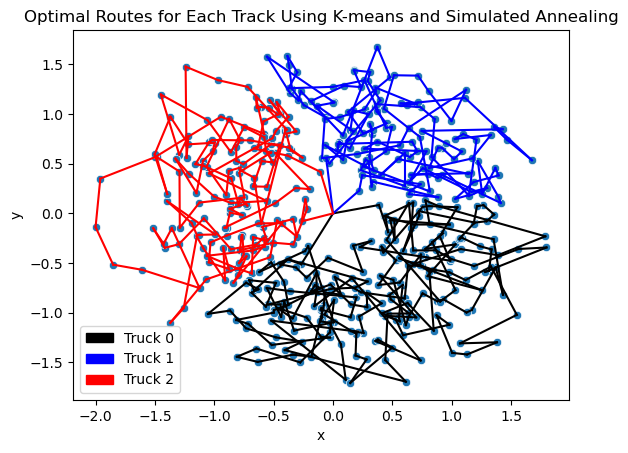

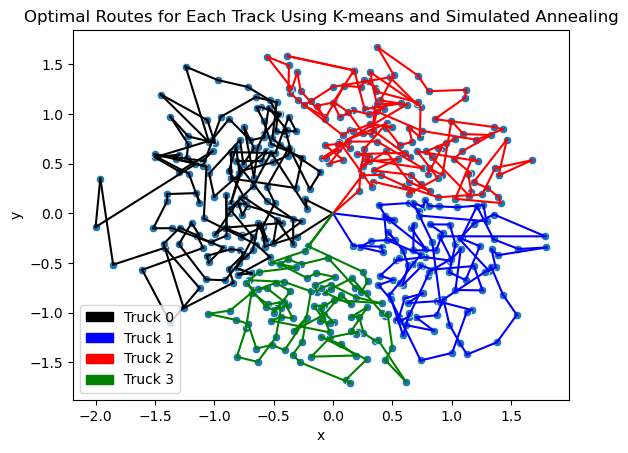

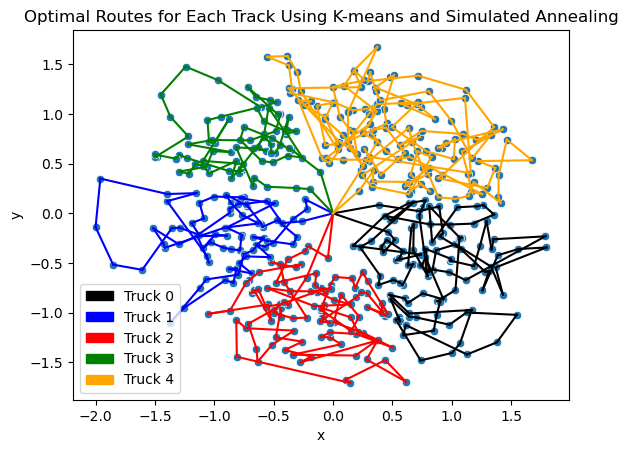

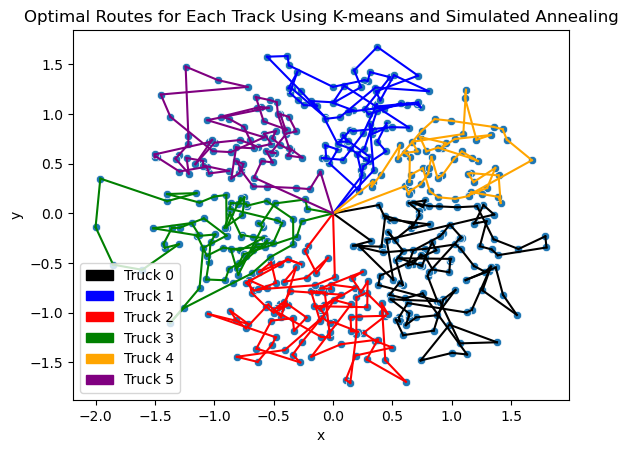

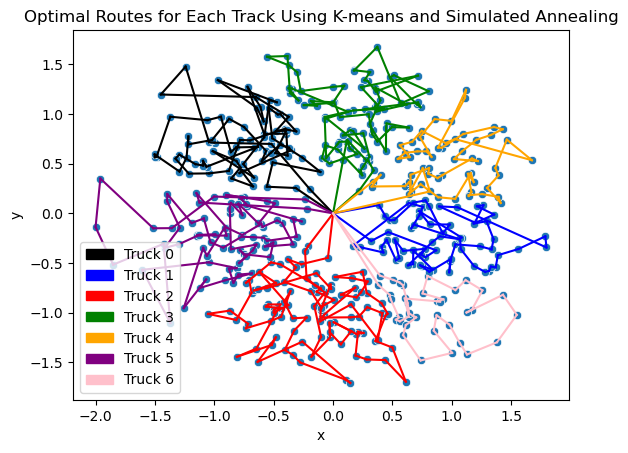

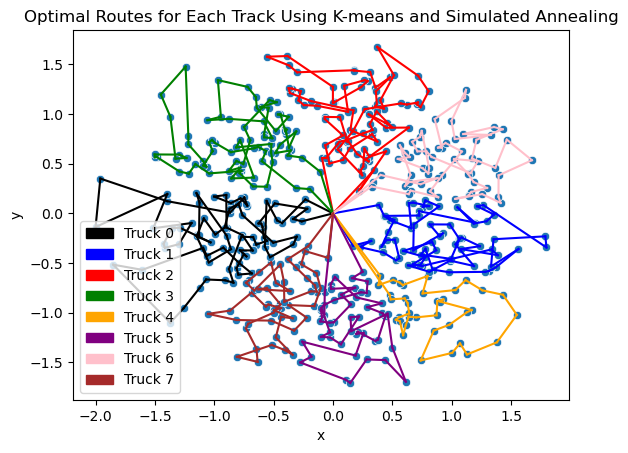

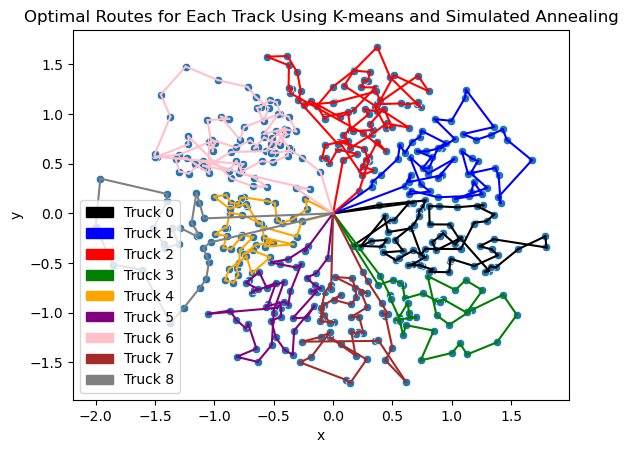

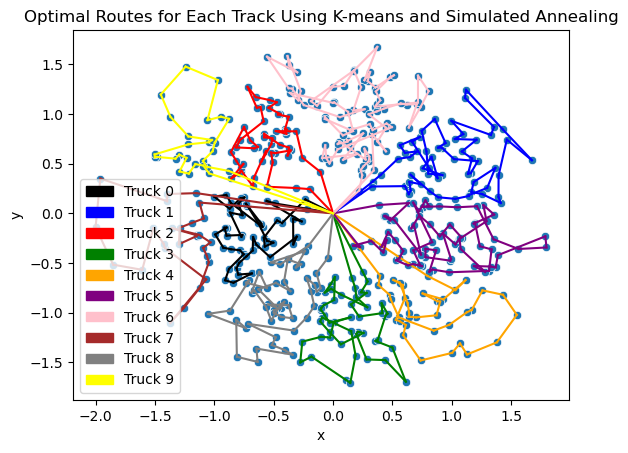

In [19]:
# For each k, plot the graph showing the traveling routes for all clusters/trucks
for k in range(1,11):
    import matplotlib.patches as mpatches
    # Plot the graph showing the traveling routes for all clusters/trucks
    color_list = ['black','blue','red','green','orange','purple','pink','brown','gray','yellow']
    sns.scatterplot(x='x',y='y',data=df1)
    # Create a dictionary to store the legend
    label_dict = {}
    # Plot the routes for each cluster
    for i in range(len(optimal_route_list_in_each_K_mean[k-1])):
        for j in range(len(optimal_route_list_in_each_K_mean[k-1][i])):
            # Find the coordinates of each location in the route
            x = df_list[k-1][i].iloc[optimal_route_list_in_each_K_mean[k-1][i][j]]['x']
            y = df_list[k-1][i].iloc[optimal_route_list_in_each_K_mean[k-1][i][j]]['y']
            if j != 0:
                plt.plot([df_list[k-1][i].iloc[optimal_route_list_in_each_K_mean[k-1][i][j]]['x'], df_list[k-1][i].iloc[optimal_route_list_in_each_K_mean[k-1][i][j-1]]['x']],[df_list[k-1][i].iloc[optimal_route_list_in_each_K_mean[k-1][i][j]]['y'], df_list[k-1][i].iloc[optimal_route_list_in_each_K_mean[k-1][i][j-1]]['y']],color=color_list[i])
            if j == len(optimal_route_list_in_each_K_mean[k-1][i])-1:
                plt.plot([df_list[k-1][i].iloc[optimal_route_list_in_each_K_mean[k-1][i][j]]['x'], df_list[k-1][i].iloc[optimal_route_list_in_each_K_mean[k-1][i][0]]['x']],[df_list[k-1][i].iloc[optimal_route_list_in_each_K_mean[k-1][i][j]]['y'], df_list[k-1][i].iloc[optimal_route_list_in_each_K_mean[k-1][i][0]]['y']],color=color_list[i])
        label_dict[i] = mpatches.Patch(color=color_list[i], label='Truck '+str(i))
        plt.legend(handles=label_dict.values())
        plt.title('Optimal Routes for Each Track Using K-means and Simulated Annealing')
    plt.show()

In [20]:
# Find the k that gives the least cost
least_cost = 1000000000
least_k = 0
for k in range(1,11):
    print('k means',k)
    print('The total distance travelled:',sum(optimal_dist_list_in_each_K_mean[k-1]))
    print('the cost of drivers', 300 * k)
    print('the total cost', 300 * k + sum(optimal_dist_list_in_each_K_mean[k-1]))
    if least_cost > 300 * k + sum(optimal_dist_list_in_each_K_mean[k-1]):
        least_cost = 300 * k + sum(optimal_dist_list_in_each_K_mean[k-1])
        least_k = k

k means 1
The total distance travelled: 223.85386913967685
the cost of drivers 300
the total cost 523.8538691396768
k means 2
The total distance travelled: 156.65146355608442
the cost of drivers 600
the total cost 756.6514635560844
k means 3
The total distance travelled: 132.25940274897877
the cost of drivers 900
the total cost 1032.2594027489788
k means 4
The total distance travelled: 119.10939059411493
the cost of drivers 1200
the total cost 1319.109390594115
k means 5
The total distance travelled: 111.62982853571646
the cost of drivers 1500
the total cost 1611.6298285357166
k means 6
The total distance travelled: 102.93433831497137
the cost of drivers 1800
the total cost 1902.9343383149715
k means 7
The total distance travelled: 99.6254926776368
the cost of drivers 2100
the total cost 2199.625492677637
k means 8
The total distance travelled: 91.38711213193871
the cost of drivers 2400
the total cost 2491.387112131939
k means 9
The total distance travelled: 89.16094499818014
the cost 

In [21]:
# One driver is the optimal solution, with the least cost
print('The least cost is',least_cost)
print('The least k',least_k)

The least cost is 523.8538691396768
The least k 1


# New Packages

If deliver based on the route of yesterday's delivery:

In [22]:
# Reset the variables for data set 1

# Put each cluster into a dataframe
dfc0 = df1.loc[df1['cluster'] == 0].reset_index(drop=False)
dfc1 = df1.loc[df1['cluster'] == 1].reset_index(drop=False)
dfc2 = df1.loc[df1['cluster'] == 2].reset_index(drop=False)
dfc3 = df1.loc[df1['cluster'] == 3].reset_index(drop=False)
dfc4 = df1.loc[df1['cluster'] == 4].reset_index(drop=False)
dfc5 = df1.loc[df1['cluster'] == 5].reset_index(drop=False)
dfc6 = df1.loc[df1['cluster'] == 6].reset_index(drop=False)
dfc7 = df1.loc[df1['cluster'] == 7].reset_index(drop=False)
dfc8 = df1.loc[df1['cluster'] == 8].reset_index(drop=False)
dfc9 = df1.loc[df1['cluster'] == 9].reset_index(drop=False)

#Add the distribution center to each cluster
dfc0.loc[len(dfc0)] = [500, 0, 0, 10]
dfc1.loc[len(dfc1)] = [500, 0, 0, 10]
dfc2.loc[len(dfc2)] = [500, 0, 0, 10]
dfc3.loc[len(dfc3)] = [500, 0, 0, 10]
dfc4.loc[len(dfc4)] = [500, 0, 0, 10]
dfc5.loc[len(dfc5)] = [500, 0, 0, 10]
dfc6.loc[len(dfc6)] = [500, 0, 0, 10]
dfc7.loc[len(dfc7)] = [500, 0, 0, 10]
dfc8.loc[len(dfc8)] = [500, 0, 0, 10]
dfc9.loc[len(dfc9)] = [500, 0, 0, 10]

#Append all the cluster dataframes into a list
df_list = []
df_list.append(dfc0)
df_list.append(dfc1)
df_list.append(dfc2)
df_list.append(dfc3)
df_list.append(dfc4)
df_list.append(dfc5)
df_list.append(dfc6)
df_list.append(dfc7)
df_list.append(dfc8)
df_list.append(dfc9)

In [23]:
# Read in the new data
df2 = pd.read_csv('locations2.csv')

# For each location in the original data, find the closest location in the new data
new_package_clusters=[[] for i in range(10)]
delivered = []
for cluster in range(clusters):
    for location in range(len(df_list[cluster])):
        location_number = -1
        for new_location in range(len(df2)):
            if new_location not in delivered:
                distance = np.sqrt((df_list[cluster].loc[location].x-df2.loc[new_location].x)**2 + (df_list[cluster].loc[location].y-df2.loc[new_location].y)**2)
                # If there is a possible undelivered location that's really close, assign it to the current cluster / truck
                if distance < 0.25:
                    location_number = new_location
                    delivered.append(location_number)
                    new_package_clusters[cluster].append(location_number)

In [24]:
# Distance threshold of less than 0.24 delivers only 499 packages
# Distance threshold of less than 0.25 perfectly delivers all packages
unique = []
for cluster in range(clusters):
    for location in new_package_clusters[cluster]:
        if location not in unique:
            unique.append(location)
len(unique)

500

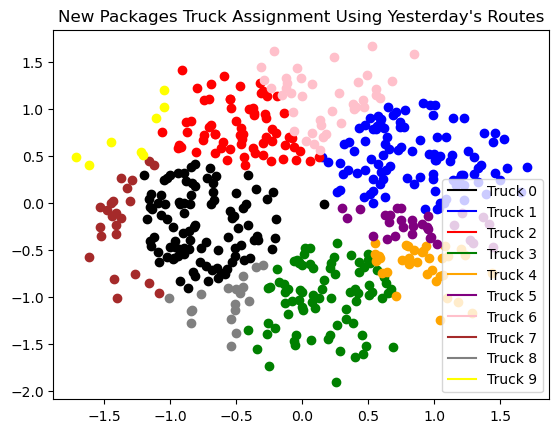

In [25]:
color_list = ['black','blue','red','green','orange','purple','pink','brown','gray','yellow']
label_dict = {}
for cluster in range(clusters):
    if color_list[cluster] not in label_dict:
        label_dict[color_list[cluster]] = f'Truck {cluster}'
    for location in new_package_clusters[cluster]:
        plt.plot(df2.loc[location].x,df2.loc[location].y, color = color_list[cluster], marker = 'o')
plt.title("New Packages Truck Assignment Using Yesterday's Routes")

# Print the legend
for color, label in label_dict.items():
    plt.plot([], [], color=color, label=label)
plt.legend()

In [26]:
new_package_cluster_dist =[]
for cluster in range(clusters):
    distance = 0 
    for location in range(len(new_package_clusters[cluster])):
        if location != 0:
            distance += np.sqrt((df2.loc[new_package_clusters[cluster][location]].x-df2.loc[new_package_clusters[cluster][location-1]].x)**2 + (df2.loc[new_package_clusters[cluster][location]].y-df2.loc[new_package_clusters[cluster][location-1]].y)**2)
        if location == len(new_package_clusters[cluster])-1:
            distance += np.sqrt((df2.loc[new_package_clusters[cluster][location]].x-df2.loc[new_package_clusters[cluster][0]].x)**2 + (df2.loc[new_package_clusters[cluster][location]].y-df2.loc[new_package_clusters[cluster][0]].y)**2)
    new_package_cluster_dist.append(distance)

for cluster in range(clusters):
    print('Truck '+str(cluster)+' will travel '+str(new_package_cluster_dist[cluster])+' miles.')

Truck 0 will travel 28.700305649312277 miles.
Truck 1 will travel 29.908519946941233 miles.
Truck 2 will travel 17.124683356468267 miles.
Truck 3 will travel 23.889681712491477 miles.
Truck 4 will travel 8.149040839843487 miles.
Truck 5 will travel 7.080143009170482 miles.
Truck 6 will travel 10.703894391150058 miles.
Truck 7 will travel 6.495322254945963 miles.
Truck 8 will travel 4.378256091989935 miles.
Truck 9 will travel 2.408257783665378 miles.


In [27]:
based_on_yester_dist = sum(new_package_cluster_dist)
print('Total miles traveled: ', based_on_yester_dist)

Total miles traveled:  138.83810503597857


If deliver based on model started from scrach:

In [28]:
# Read in the new data
df2 = pd.read_csv('locations2.csv')

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


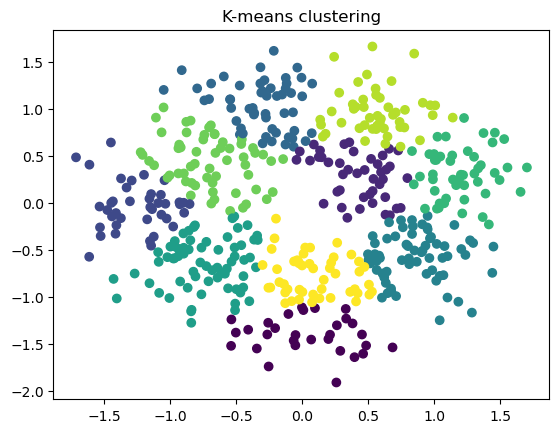

In [29]:
# Find the location clusters using K-means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
kmeans.fit(df2)
df2['cluster'] = kmeans.labels_

# Plot the clusters
plt.scatter(df2['x'], df2['y'], c=df2['cluster'])
plt.title('K-means clustering')
plt.show()

In [30]:
# Put each cluster into a dataframe
df2c0 = df2.loc[df2['cluster'] == 0].reset_index(drop=False)
df2c1 = df2.loc[df2['cluster'] == 1].reset_index(drop=False)
df2c2 = df2.loc[df2['cluster'] == 2].reset_index(drop=False)
df2c3 = df2.loc[df2['cluster'] == 3].reset_index(drop=False)
df2c4 = df2.loc[df2['cluster'] == 4].reset_index(drop=False)
df2c5 = df2.loc[df2['cluster'] == 5].reset_index(drop=False)
df2c6 = df2.loc[df2['cluster'] == 6].reset_index(drop=False)
df2c7 = df2.loc[df2['cluster'] == 7].reset_index(drop=False)
df2c8 = df2.loc[df2['cluster'] == 8].reset_index(drop=False)
df2c9 = df2.loc[df2['cluster'] == 9].reset_index(drop=False)

#Add the distribution center to each cluster
df2c0.loc[len(df2c0)] = [500, 0, 0, 10]
df2c1.loc[len(df2c1)] = [500, 0, 0, 10]
df2c2.loc[len(df2c2)] = [500, 0, 0, 10]
df2c3.loc[len(df2c3)] = [500, 0, 0, 10]
df2c4.loc[len(df2c4)] = [500, 0, 0, 10]
df2c5.loc[len(df2c5)] = [500, 0, 0, 10]
df2c6.loc[len(df2c6)] = [500, 0, 0, 10]
df2c7.loc[len(df2c7)] = [500, 0, 0, 10]
df2c8.loc[len(df2c8)] = [500, 0, 0, 10]
df2c9.loc[len(df2c9)] = [500, 0, 0, 10]

#Append all the cluster dataframes into a list
df_list2 = []
df_list2.append(df2c0)
df_list2.append(df2c1)
df_list2.append(df2c2)
df_list2.append(df2c3)
df_list2.append(df2c4)
df_list2.append(df2c5)
df_list2.append(df2c6)
df_list2.append(df2c7)
df_list2.append(df2c8)
df_list2.append(df2c9)

In [31]:
# Store the distance matrices in a list
clusters = 10
list_of_distance_matrices2 = []
for cluster in range(clusters):
    list_of_distance_matrices2.append(get_distance_matrix(df_list2[cluster]))

In [32]:
# Find the optimal distance for each cluster/truck
optimal_distances2 = []
route_for_each_cluster2 = []
for cluster in range(clusters):
    print('Working on cluster', cluster)
    N = df_list2[cluster].shape[0]
    mod2 = gp.Model()
    x2 = mod2.addMVar((N,N),vtype='B')
    u2 = mod2.addMVar(N)

    # enter each city once, j fixed
    # each column add to 1
    enter2 = mod2.addConstrs((gp.quicksum(x2[i,j] for i in range(N))==1) for j in range(N))
    # leave each city once, i fixed
    # each row add to 1
    leave2 = mod2.addConstrs((gp.quicksum(x2[i,j] for j in range(N))==1) for i in range(N))
    # u constraints
    ucons2 = mod2.addConstrs((u2[i] - u2[j] + N*x2[i,j] <= (N-1)) for i in range(1,N) for j in range(1,N) if i != j)

    # i is the row here, j is the column
    mod2.setObjective(gp.quicksum(x2[i,j]*list_of_distance_matrices2[cluster][i,j] for i in range(N) for j in range(N)))

    mod2.Params.OutputFlag = 0 # tell gurobi to shut up!!
    mod2.setParam('TimeLimit', 5*60) # 5 minutes time limit
    mod2.optimize()

    optimal_distances2.append(mod2.objVal)
    route_for_each_cluster2.append(x2.x)

Working on cluster 0
Working on cluster 1
Working on cluster 2
Working on cluster 3
Working on cluster 4
Working on cluster 5
Working on cluster 6
Working on cluster 7
Working on cluster 8
Working on cluster 9


In [33]:
# Print the optimal route for each cluster/truck in a readable format
for cluster in range(clusters):
    print(f'Optimal route for truck (cluster) number: {cluster}')
    N = df_list2[cluster].shape[0]
    where = 0
    miles_traveled = 0
    print('Start at the distribution center, location = 0')
    for location in reversed(range(N)):
        # Start in the new location (go to the row with the new city)
        # We find the next location by using where() to find the first nonzero element (logical indexing, 1 = True) in the row
        where_new = np.where(route_for_each_cluster2[cluster][where,:])[0][0]
        dist = list_of_distance_matrices2[cluster][where,where_new]
        miles_traveled += dist
        print('Then go to location '+str(df_list2[cluster]['index'].iloc[where_new])+', traveling '+str(dist)+' miles along the way.')
        # Store the next location as the starting location, since we have now traveled to it
        where = where_new
    print('For a total of '+str(miles_traveled)+' miles.')
    print()

Optimal route for truck (cluster) number: 0
Start at the distribution center, location = 0
Then go to location 372, traveling 0.15336250602683557 miles along the way.
Then go to location 381, traveling 0.08990062634937611 miles along the way.
Then go to location 424, traveling 0.07751631796243114 miles along the way.
Then go to location 371, traveling 0.17894439381794566 miles along the way.
Then go to location 370, traveling 0.12449494669542494 miles along the way.
Then go to location 400, traveling 0.03127327636949365 miles along the way.
Then go to location 384, traveling 0.09024260938723071 miles along the way.
Then go to location 500, traveling 1.1216299388987834 miles along the way.
Then go to location 418, traveling 1.1732998918118942 miles along the way.
Then go to location 374, traveling 0.10278852030106775 miles along the way.
Then go to location 385, traveling 0.09990353830756829 miles along the way.
Then go to location 402, traveling 0.12034297416395963 miles along the way.

Text(0.5, 1.0, 'Optimal Routes for Each Truck')

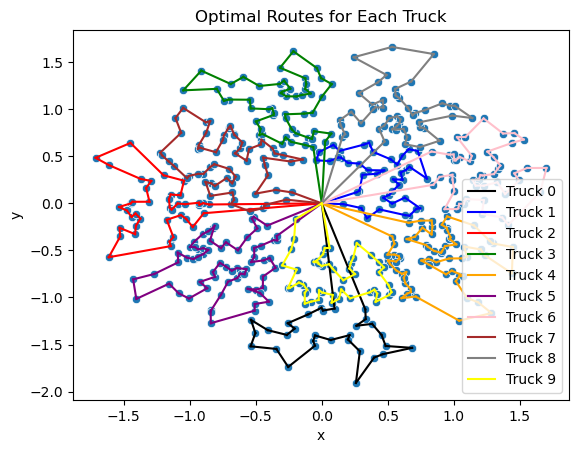

In [34]:
# Plot the graph showing the traveling routes for all clusters/trucks
color_list = ['black','blue','red','green','orange','purple','pink','brown','gray','yellow']
sns.scatterplot(x='x',y='y',data=df2)
# Create a dictionary to store the legend
label_dict = {}
# Plot the routes
for cluster in range(clusters):
    N = df_list2[cluster].shape[0]
    if color_list[cluster] not in label_dict:
        label_dict[color_list[cluster]] = f'Truck {cluster}'
    for i in range(N):
        for j in range(N):
            if route_for_each_cluster2[cluster][i,j] > 0.9:
                plt.plot([df_list2[cluster].x[i],df_list2[cluster].x[j]],[df_list2[cluster].y[i],df_list2[cluster].y[j]],color=color_list[cluster])
# Print the legend
for color, label in label_dict.items():
    plt.plot([], [], color=color, label=label)
plt.legend()
plt.title("Optimal Routes for Each Truck")

In [35]:
# Sum of the optimal distances for all clusters/trucks
based_on_today_dist = sum(optimal_distances2)
print('The total distance traveled by all trucks is', based_on_today_dist, 'miles.')

The total distance traveled by all trucks is 63.811614288777 miles.


Difference in distance between using yesterday's route and setting up a new model:

In [36]:
based_on_yester_dist- based_on_today_dist

75.02649074720156

We can see the difference between using the optimal routes from yesterday vs. starting a new model is very large. We more than doubled our distance by not starting a new model, suggesting starting a model each day is the best practice.

# Other ways to split up the nodes

Another way to divide up the nodes is with Gaussian mixture. 

GMM may be better than K-means in certain scenarios for several reasons:

* Flexibility: GMM is more flexible in modeling the shape and size of clusters compared to K-means. K-means assumes that clusters are spherical and equally sized, whereas GMM can model clusters of different shapes and sizes.

* Soft clustering: GMM provides a soft clustering approach, which means that each data point is assigned a probability of belonging to each cluster. This is useful when a data point could belong to more than one cluster or when a cluster overlaps with another.

* Capturing variance: GMM models each cluster as a combination of Gaussian distributions, allowing it to capture the variance within each cluster. K-means only considers the mean of each cluster, which may not be representative of the entire cluster.

* Better for non-linearly separable data: K-means may struggle with non-linearly separable data, where data points in the same cluster may not be close to each other. GMM, on the other hand, can capture the complex relationship between data points and their probability of belonging to each cluster.

However, it's important to note that GMM is computationally more expensive than K-means and requires more tuning of its hyperparameters. The choice between the two algorithms ultimately depends on the nature of the data and the goals of the analysis.

Since our data do not have visually well-separated clusters, GMM might be a better approach than K-means.

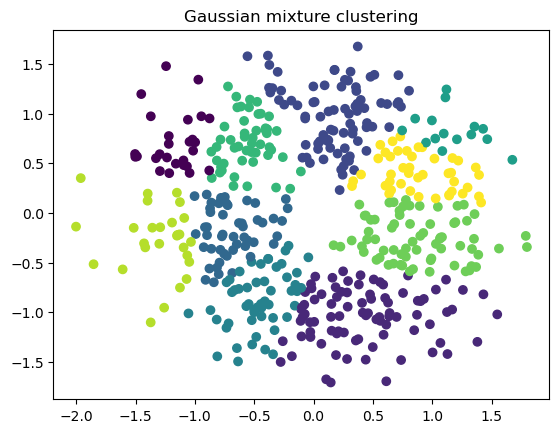

In [37]:
from sklearn.mixture import GaussianMixture
import copy

gmm = GaussianMixture(10, 
                     covariance_type='full', 
                     random_state=0).fit(df1)
df1['cluster'] = gmm.predict(df1)
df1

# Plot the clusters
plt.scatter(df1['x'], df1['y'], c=df1['cluster'])
plt.title('Gaussian mixture clustering')
plt.show()  

In [38]:
# Reset the variables for dataset 1

# Put each cluster into a dataframe
dfc0 = df1.loc[df1['cluster'] == 0].reset_index(drop=False)
dfc1 = df1.loc[df1['cluster'] == 1].reset_index(drop=False)
dfc2 = df1.loc[df1['cluster'] == 2].reset_index(drop=False)
dfc3 = df1.loc[df1['cluster'] == 3].reset_index(drop=False)
dfc4 = df1.loc[df1['cluster'] == 4].reset_index(drop=False)
dfc5 = df1.loc[df1['cluster'] == 5].reset_index(drop=False)
dfc6 = df1.loc[df1['cluster'] == 6].reset_index(drop=False)
dfc7 = df1.loc[df1['cluster'] == 7].reset_index(drop=False)
dfc8 = df1.loc[df1['cluster'] == 8].reset_index(drop=False)
dfc9 = df1.loc[df1['cluster'] == 9].reset_index(drop=False)

#Add the distribution center to each cluster
dfc0.loc[len(dfc0)] = [500, 0, 0, 10]
dfc1.loc[len(dfc1)] = [500, 0, 0, 10]
dfc2.loc[len(dfc2)] = [500, 0, 0, 10]
dfc3.loc[len(dfc3)] = [500, 0, 0, 10]
dfc4.loc[len(dfc4)] = [500, 0, 0, 10]
dfc5.loc[len(dfc5)] = [500, 0, 0, 10]
dfc6.loc[len(dfc6)] = [500, 0, 0, 10]
dfc7.loc[len(dfc7)] = [500, 0, 0, 10]
dfc8.loc[len(dfc8)] = [500, 0, 0, 10]
dfc9.loc[len(dfc9)] = [500, 0, 0, 10]

#Append all the cluster dataframes into a list
df_list = []
df_list.append(dfc0)
df_list.append(dfc1)
df_list.append(dfc2)
df_list.append(dfc3)
df_list.append(dfc4)
df_list.append(dfc5)
df_list.append(dfc6)
df_list.append(dfc7)
df_list.append(dfc8)
df_list.append(dfc9)

After splitting the data, we can then use simulated annealing on each cluster to find the optimal route for each cluster. Simulated annealing can help us save some time compared to Gurobi.

In [39]:
dist_list = []
for df in df_list:
    # The code below is to calculate the distance between each pair of locations
    nx = df.shape[0]
    dist = np.zeros((nx,nx))
    for i in range(nx):
        for j in range(nx):
            # If the two locations are the same, set the distance to be a large number
            if i == j:
                dist[i,j] = 10000
            # Else calculate the distance between the two locations
            else:
                dist[i,j] = np.sqrt((df['x'][i]-df['x'][j])**2 + (df['y'][i]-df['y'][j])**2)
    dist_list.append(dist)

In [40]:
optimal_route_list = []
optimal_dist_list = []
for cluster in range(len(df_list)):
    nx = df_list[cluster].shape[0]
    path = np.random.choice(nx,nx,False)
    nloop = 100000
    eps = 1
    delta = 1/nloop
    total_dist = measure_path(path,dist_list[cluster])
    # Randomly choose a method to generate a new path
    for j in range(nloop):
        if np.random.random() < 0.5:
            newpath = transport(path)
        else:
            newpath = reverse(path)
        newdist = measure_path(newpath,dist_list[cluster])
        # If the new path is shorter, we accept the new path
        if newdist < total_dist:
            path = newpath
            total_dist = newdist
        # If the new path is longer, we accept the new path with a probability
        # This is to prevent us from entering a local minimum
        # The more distance we add, the less likely we are to accept the new path
        else:
            if np.random.random() < eps/np.exp(newdist-total_dist):
                path = newpath
                total_dist = newdist
        # Every loop we reduce the probability of accepting the new path
        eps -= delta
    optimal_route_list.append(path)
    optimal_dist_list.append(total_dist)

In [41]:
# Print the optimal route and the total distance for each cluster
for i in range(len(optimal_route_list)):
    print('For cluster:',i)
    print('Optimal route:',optimal_route_list[i])
    print('Total distance:',optimal_dist_list[i])

For cluster: 0
Optimal route: [ 8  7 18 21  9 13 20 12  0  2  1  6  3 27 25  5 22 24 14 19 15 23 26 16
 10 11  4 17]
Total distance: 6.403150579569481
For cluster: 1
Optimal route: [56 24 10 35 58 61 23 17 11 19 13 14  2 74 20 32 52 39 36 12 33  8 43 29
 78 60 86  1 82 46 83 48 67 51 49 21 18 38 75 59  7 45 40 80 28  5 64 55
 16 62 66 85 72  0 79 42 73 65 63 34 76 27 69 68 70 77 84 71 81 30 54 47
 44  3 37 31 57 50 53 15  4  9 26 41 22  6 25]
Total distance: 18.100712940582405
For cluster: 2
Optimal route: [28 20 53 44 67 41  6 26 21 42  8 11 14 76 30 17 80 32 12  9  4 81 39 56
 38 65 58  1  7 79 54 36 25 16 10 43  5 73 52 70 66 78 59 27 50 62 47 35
 74 29 71 60 61 63 46 69 13 45 68 64 57 48 33 19 24 51 34 55 77 22 49  2
 18 23  0 37  3 15 31 40 72 75]
Total distance: 14.13023188973477
For cluster: 3
Optimal route: [16  0 26 46 42 35 48 10 43 24 12 45 20 32 30 13  6 28 15 17 40  3 25  9
 29  2 36  4  1 44 19 27  7  5 41 50 14 18 22 37 21 34 39 49 11 33 31 23
 38  8 47]
Total distance: 

In [42]:
# Print the total distance for all clusters
print('Total distance for all clusters:',sum(optimal_dist_list))

Total distance for all clusters: 91.44573948897107


Text(0.5, 1.0, 'Optimal Routes for Each Track Using GMM and Simulated Annealing')

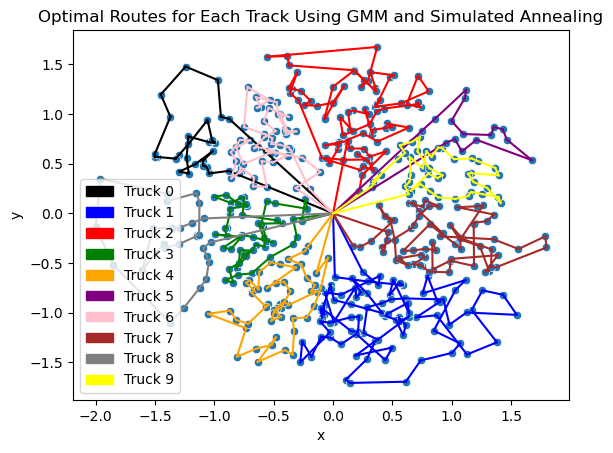

In [43]:
import matplotlib.patches as mpatches
# Plot the graph showing the traveling routes for all clusters/trucks
color_list = ['black','blue','red','green','orange','purple','pink','brown','gray','yellow']
sns.scatterplot(x='x',y='y',data=df1)
# Create a dictionary to store the legend
label_dict = {}
# Plot the routes for each cluster
for i in range(len(optimal_route_list)):
    for j in range(len(optimal_route_list[i])):
        # Find the coordinates of each location in the route
        x = df_list[i].iloc[optimal_route_list[i][j]]['x']
        y = df_list[i].iloc[optimal_route_list[i][j]]['y']
        if j != 0:
            plt.plot([df_list[i].iloc[optimal_route_list[i][j]]['x'], df_list[i].iloc[optimal_route_list[i][j-1]]['x']],[df_list[i].iloc[optimal_route_list[i][j]]['y'], df_list[i].iloc[optimal_route_list[i][j-1]]['y']],color=color_list[i])
        if j == len(optimal_route_list[i])-1:
            plt.plot([df_list[i].iloc[optimal_route_list[i][j]]['x'], df_list[i].iloc[optimal_route_list[i][0]]['x']],[df_list[i].iloc[optimal_route_list[i][j]]['y'], df_list[i].iloc[optimal_route_list[i][0]]['y']],color=color_list[i])
    label_dict[i] = mpatches.Patch(color=color_list[i], label='Truck '+str(i))
plt.legend(handles=label_dict.values())
plt.title('Optimal Routes for Each Track Using GMM and Simulated Annealing')